# 1. Análsis Exploratorio

Shampoo Dataset Head:
  Month  Sales
0  1-01  266.0
1  1-02  145.9
2  1-03  183.1
3  1-04  119.3
4  1-05  180.3

Shampoo Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 708.0+ bytes
None

Shampoo Descripción Estadística:
            Sales
count   36.000000
mean   312.600000
std    148.937164
min    119.300000
25%    192.450000
50%    280.150000
75%    411.100000
max    682.000000


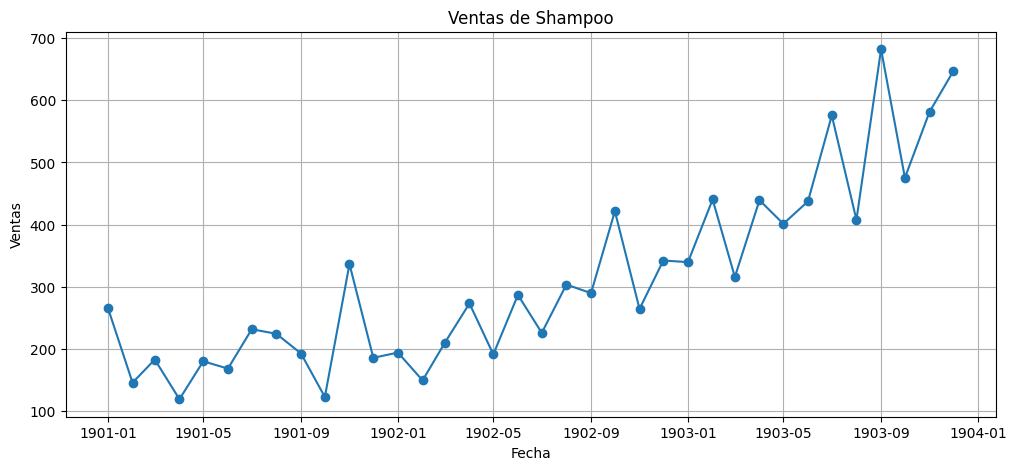


Nulos en Shampoo:
 Month    0
Sales    0
dtype: int64


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

# 1. Cargar los datos
shampoo = pd.read_csv('data/shampoo.csv')

# 2. Visualización general de los datasets
print("Shampoo Dataset Head:")
print(shampoo.head())
print("\nShampoo Info:")
print(shampoo.info())
print("\nShampoo Descripción Estadística:")
print(shampoo.describe())


# 3. Conversión de fechas para ambos datasets
shampoo['Month'] = pd.to_datetime('190' + shampoo['Month'], format='%Y-%m')

# 4. Graficar series de tiempo
plt.figure(figsize=(12,5))
plt.plot(shampoo['Month'], shampoo['Sales'], marker='o')
plt.title('Ventas de Shampoo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.grid(True)
plt.show()

# 5. Comprobar valores nulos
print("\nNulos en Shampoo:\n", shampoo.isnull().sum())


# 2. Promedios Móviles

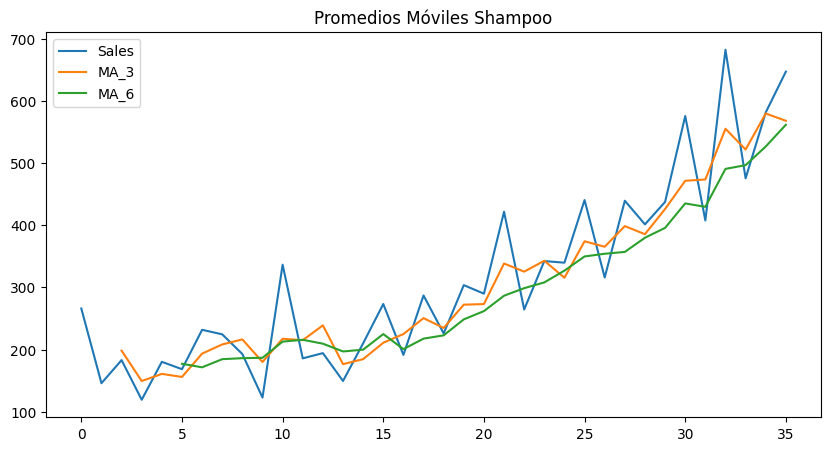

In [8]:
shampoo['MA_3'] = shampoo['Sales'].rolling(window=3).mean()
shampoo['MA_6'] = shampoo['Sales'].rolling(window=6).mean()

shampoo[['Sales', 'MA_3', 'MA_6']].plot(figsize=(10,5), title="Promedios Móviles Shampoo")
plt.show()

# 3. Alisamiento Exponencial

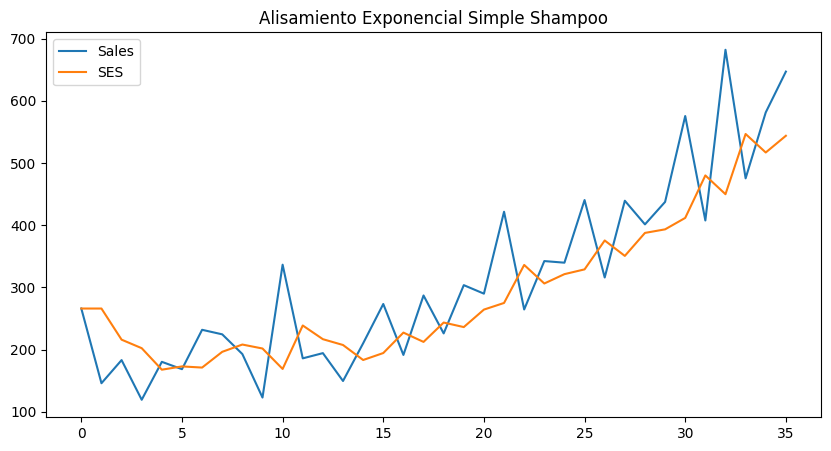

In [9]:
ses_model = SimpleExpSmoothing(shampoo['Sales']).fit()
shampoo['SES'] = ses_model.fittedvalues

shampoo[['Sales', 'SES']].plot(figsize=(10,5), title="Alisamiento Exponencial Simple Shampoo")
plt.show()

# 4. HOLT-WINTERS

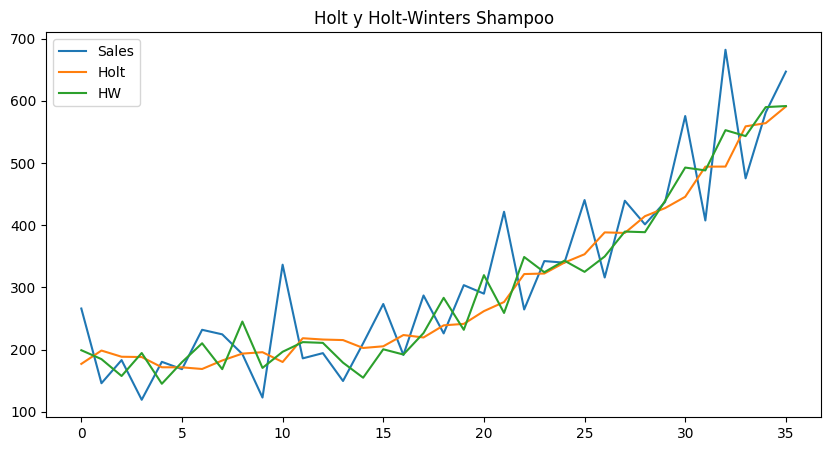

In [10]:
holt_model = ExponentialSmoothing(shampoo['Sales'], trend='add', seasonal=None).fit()
hw_model = ExponentialSmoothing(shampoo['Sales'], trend='add', seasonal='add', seasonal_periods=12).fit()

shampoo['Holt'] = holt_model.fittedvalues
shampoo['HW'] = hw_model.fittedvalues

shampoo[['Sales', 'Holt', 'HW']].plot(figsize=(10,5), title="Holt y Holt-Winters Shampoo")
plt.show()


# 5. SARIMA

/home/nelson/Documents/Uvg/Data Science/Lab1_DataScience/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/nelson/Documents/Uvg/Data Science/Lab1_DataScience/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


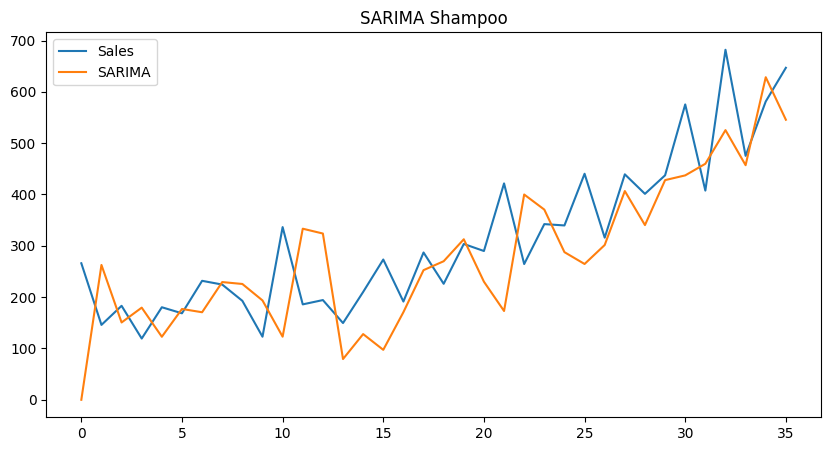

In [11]:
sarima_model = SARIMAX(shampoo['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
shampoo['SARIMA'] = sarima_model.fittedvalues

shampoo[['Sales', 'SARIMA']].plot(figsize=(10,5), title="SARIMA Shampoo")
plt.show()

# 6. Prophet

23:46:50 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing
/home/nelson/Documents/Uvg/Data Science/Lab1_DataScience/venv/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


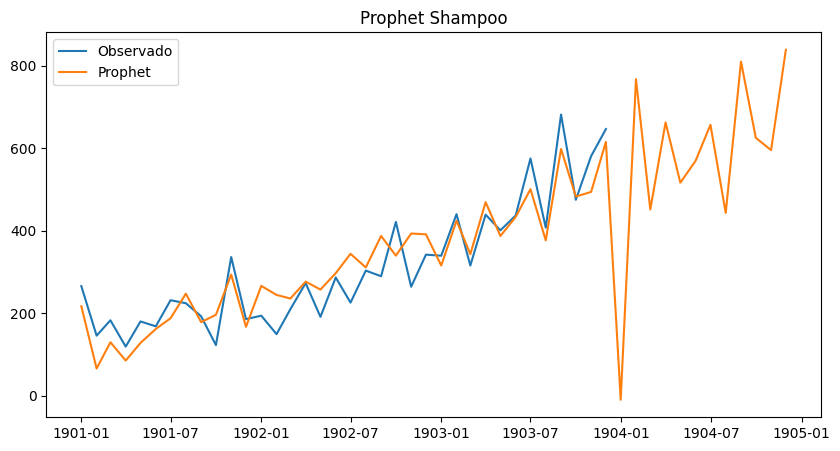

In [12]:
prophet_df = shampoo.reset_index().rename(columns={'Month':'ds', 'Sales':'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

plt.figure(figsize=(10,5))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Observado')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet')
plt.legend()
plt.title("Prophet Shampoo")
plt.show()

# 7. Comparación y Evaluación

In [14]:
def evaluate(true, pred):
    return {
        'RMSE': mean_squared_error(true, pred) ** 0.5,
        'MAE' : mean_absolute_error(true, pred)
    }

results = {
    'SES': evaluate(shampoo['Sales'], shampoo['SES']),
    'Holt': evaluate(shampoo['Sales'], shampoo['Holt']),
    'HW': evaluate(shampoo['Sales'], shampoo['HW']),
    'SARIMA': evaluate(shampoo['Sales'].iloc[1:], shampoo['SARIMA'].iloc[1:]),
    'Prophet': evaluate(prophet_df['y'], forecast['yhat'][:len(prophet_df)])
}

print("Resultados de Evaluación Shampoo:")
for model, metrics in results.items():
    print(f"{model}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}")

Resultados de Evaluación Shampoo:
SES: RMSE=82.94, MAE=65.58
Holt: RMSE=71.21, MAE=54.96
HW: RMSE=65.37, MAE=52.68
SARIMA: RMSE=99.19, MAE=77.23
Prophet: RMSE=57.55, MAE=46.57
